In [1]:
# create a list of colormap we're going to use (size C)

# cluster types (cells / neighborhoods) into <= C types

# within each type, organize types into linear order using linkage and optimal leaf ordering 

# for each type, get it's cmap and position along the cmap. 

In [3]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Visualization.Viz import *
import matplotlib.pyplot as plt 

In [4]:
TMG = TissueMultiGraph('TMG_dev5.pkl')

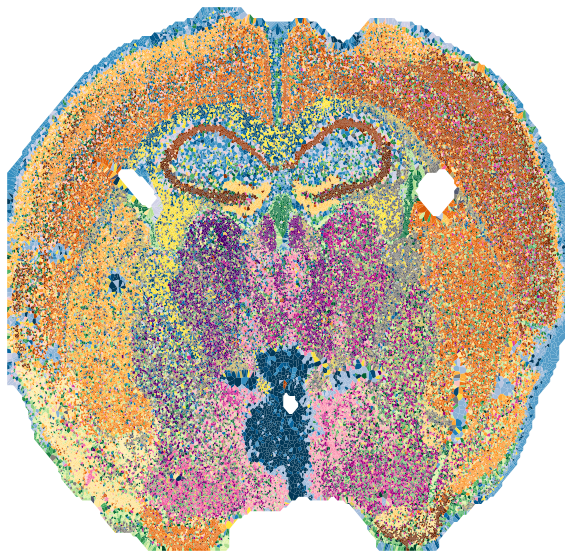

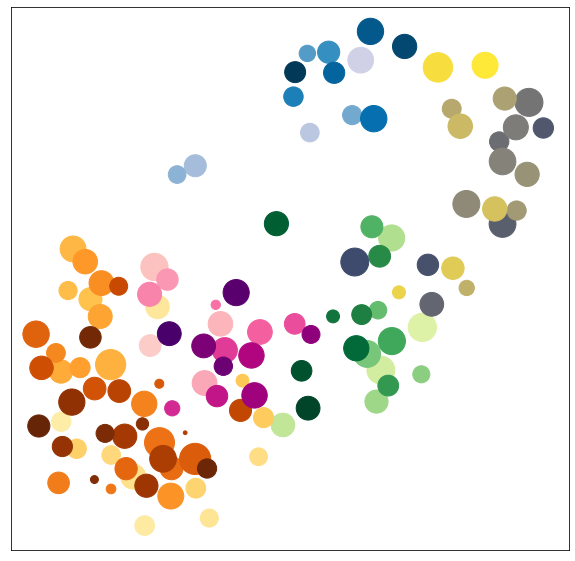

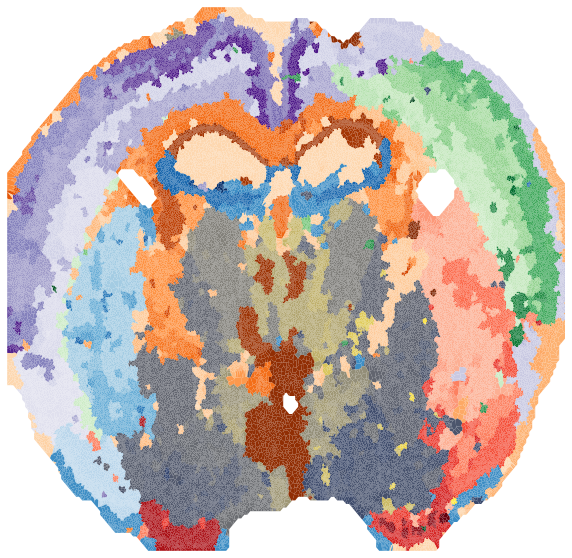

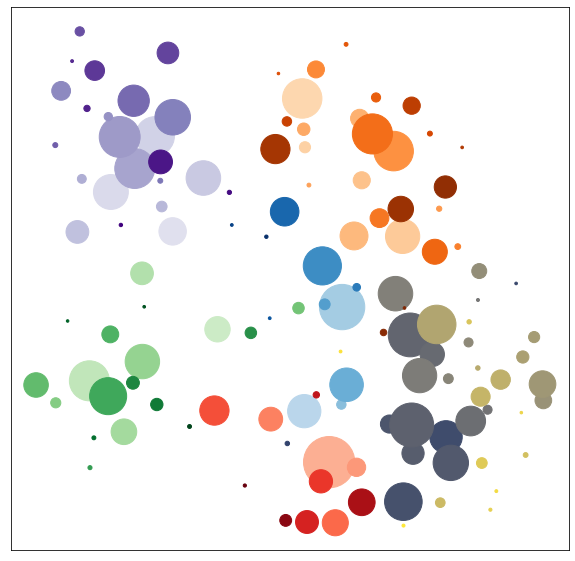

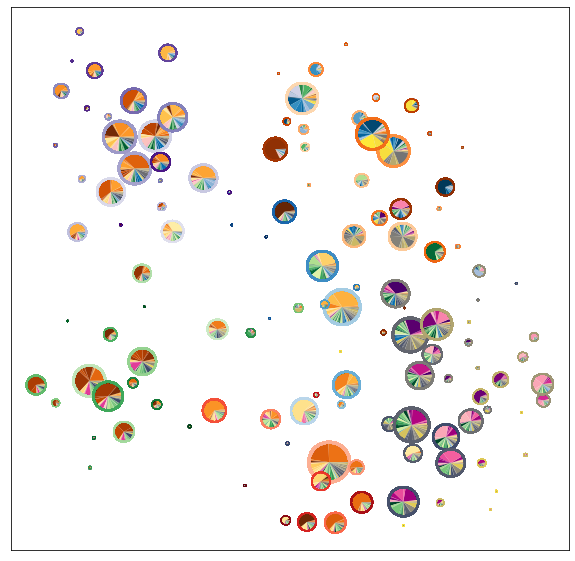

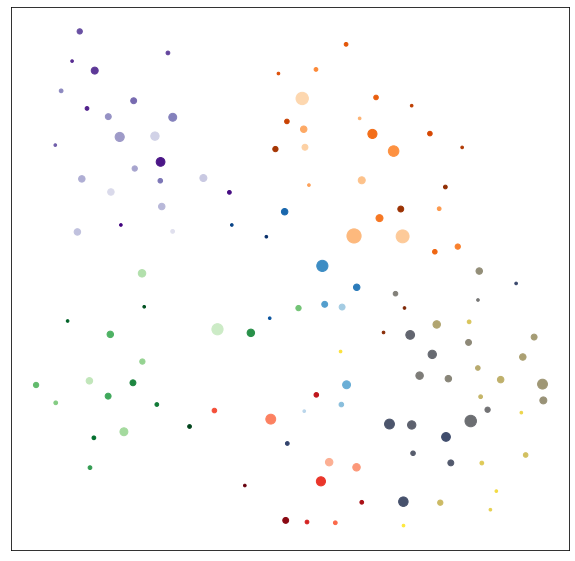

In [15]:
V1 = PolygonColorByType(TMG,name = 'custom',lvl=1,metric = 'cosine')
V1.figsize = (10,10)
V1.cmap_list = ['YlOrBr','RdPu','YlGn','PuBu','cividis']
# V1.cmap_list = ['summer','spring','cool','Wistia']
V1.set_view()
V1.plot()

V3 = PolygonColorByType(TMG,name = 'custom',lvl=3,metric = 'jensenshannon')
V3.figsize = (10,10)
V3.set_view()
V3.plot(V1)


In [6]:
pth='/home/rwollman/MyProjects/MaximallyInformativeBiocartography/FigForSlides/'
V1.figs[0].savefig(pth + 'CellMap.png')
V1.figs[1].savefig(pth + 'CellTypeScatter.png')

V3.figs[0].savefig(pth + 'RegionMap.png')
V3.figs[1].savefig(pth + 'RegionTypeScatter.png')
V3.figs[2].savefig(pth + 'RegionTypeScatterWithPies.png')
V3.figs[3].savefig(pth + 'RegionTypeScaledByUse.png')

In [16]:
TMG.Ntypes

[119, 119, 164, 125]

Text(0, 0.5, 'Freq')

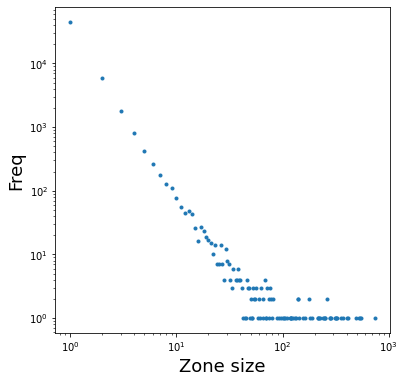

In [17]:
sz,cnt = np.unique(TMG.Layers[1].node_size,return_counts=True)
plt.figure(figsize=(6,6))
plt.loglog(sz,cnt,'.')
plt.xlabel('Zone size',fontsize=18)
plt.ylabel('Freq',fontsize=18)
# plt.savefig(pth+'Zone size distribution.png')

Text(0, 0.5, 'Freq')

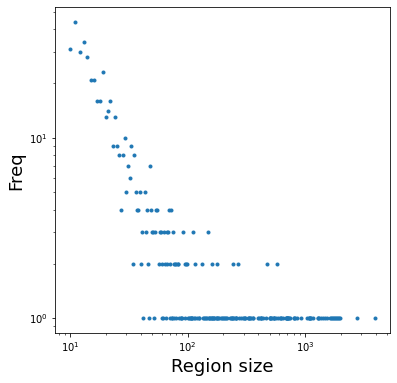

In [18]:
sz,cnt = np.unique(TMG.Layers[3].node_size,return_counts=True)
plt.figure(figsize=(6,6))
plt.loglog(sz[1:],cnt[1:],'.')
plt.xlabel('Region size',fontsize = 18)
plt.ylabel('Freq',fontsize=18)
# plt.savefig(pth+'Region size distribution.png')

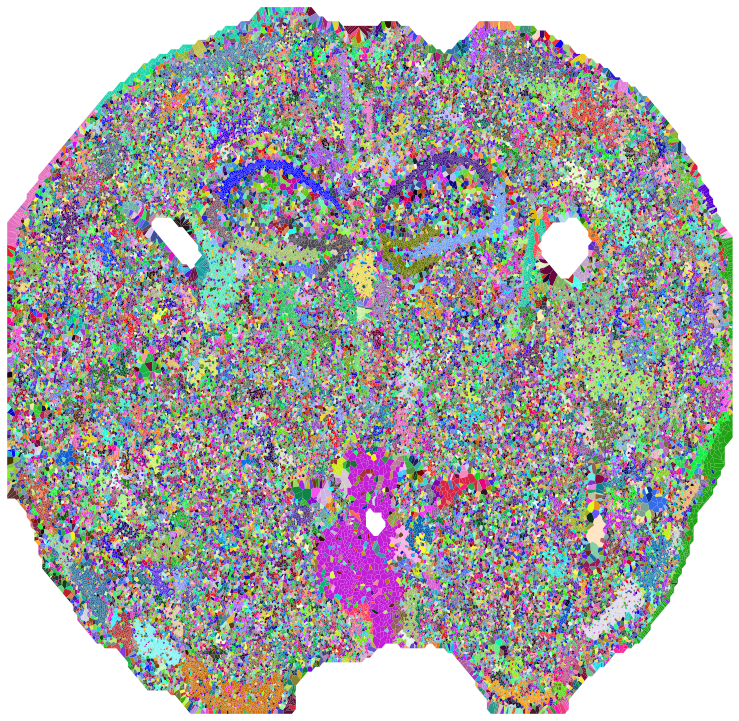

In [19]:
Vz = RandomPolygonColor(TMG,lvl=1)
Vz.set_view()
Vz.plot()
# Vz.figs[0].savefig(pth + 'ZoneMap.png')

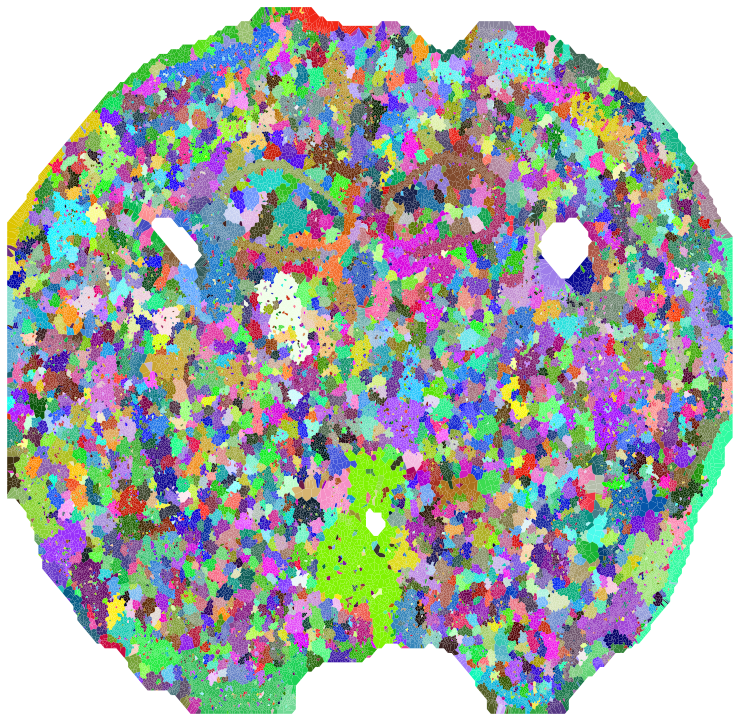

In [20]:
Vp = RandomPolygonColor(TMG,lvl=2)
Vp.set_view()
Vp.plot()
# Vp.figs[0].savefig(pth + 'Parcels.png')

TypeError: 'bool' object is not callable

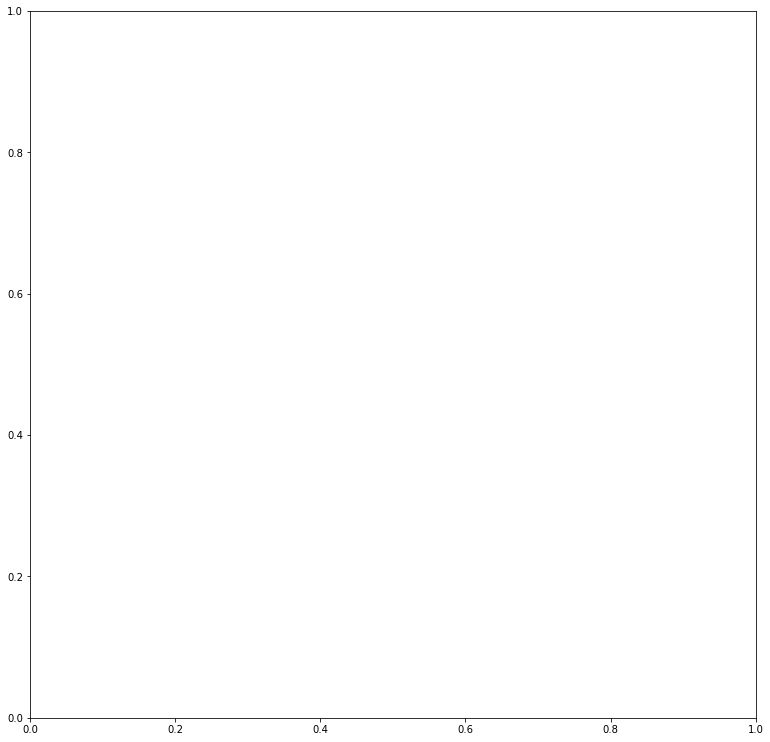

In [12]:
Vc = CoherenceView(TMG)
Vc.set_view()
Vc.plot()

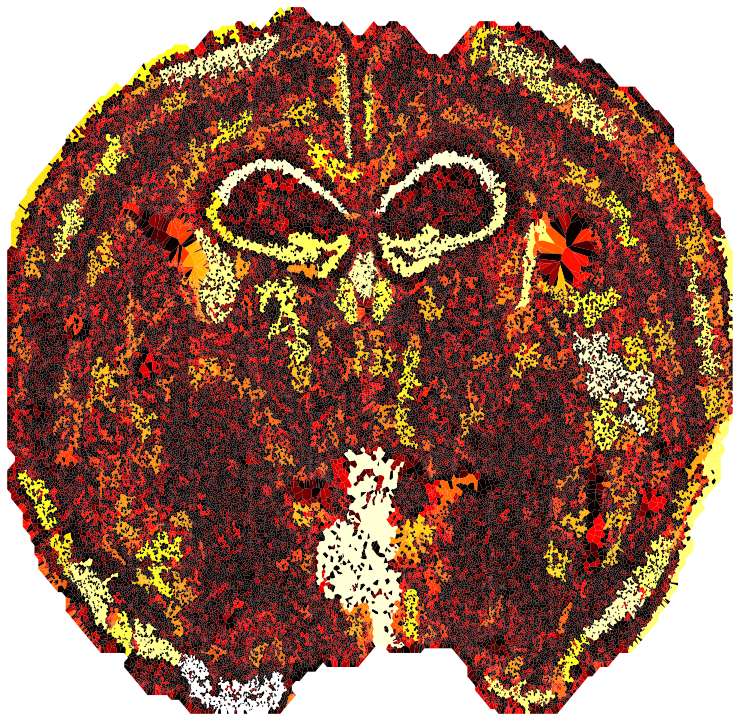

In [44]:
Vz2 = PolygonShowCustomValues(TMG,values_to_map = np.log10(TMG.Layers[1].node_size))
Vz2.set_view()
Vz2.plot()
# Vz2.figs[0].savefig(pth + 'ZoneMapColoredBySize.png')

In [190]:
mx = np.max(np.array(TMG.Geoms['BoundingBox'].exterior.xy).T,axis=0)
mn = np.min(np.array(TMG.Geoms['BoundingBox'].exterior.xy).T,axis=0)

mins = np.tile(mn, (vor.vertices.shape[0], 1))
bounded_vertices = np.max((vor.vertices, mins), axis=0)
maxs = np.tile(mx, (vor.vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

segs = list()
center = XY.mean(axis=0)
for i in range(len(vor.ridge_vertices)):
    pointidx = vor.ridge_points[i,:]
    simplex = np.asarray(vor.ridge_vertices[i])
    if np.all(simplex >= 0):
        line=[(bounded_vertices[simplex[0], 0], bounded_vertices[simplex[0], 1]),
              (bounded_vertices[simplex[1], 0], bounded_vertices[simplex[1], 1])]
    else:
        i = simplex[simplex >= 0][0] # finite end Voronoi vertex
        t = XY[pointidx[1]] - XY[pointidx[0]]  # tangent
        t = t / np.linalg.norm(t)
        n = np.array([-t[1], t[0]]) # normal
        midpoint = XY[pointidx].mean(axis=0)
        far_point = vor.vertices[i] + np.sign(np.dot(midpoint - center, n)) * n * 100
        line=[(vor.vertices[i,:]),(far_point)]
    
    LS = LineString(line)
    LS = LS.intersection(TMG.Geoms['BoundingBox'])
    if isinstance(LS,MultiLineString):
        allparts = list(LS.intersection(TMG.Geoms['BoundingBox']).geoms)
        lengths = [l.length for l in allparts]
        LS = allparts[np.argmax(lengths)]
                
    xy = np.asarray(LS.xy)
    line=xy.T
    segs.append(line)
        
# make sure the keys for edges are always sorted, a convenstion that will make life easier. 
ridge_points_sorted = np.sort(vor.ridge_points,axis=1)
keys=list()
for i in range(ridge_points_sorted.shape[0]):
    keys.append(tuple(ridge_points_sorted[i,:]))

TMG.Geoms['line'] = dict(zip(keys, segs))

In [216]:
class OnlyLines(View):
    def __init__(self,TMG,lvl,name = "only lines"):
        super().__init__(TMG,name = name)
        self.edge_levels = None
        self.edge_list = None
        self.segs = list()
        self.lvl = lvl
        self.lvl_widths = np.array([0.25,0.5,1,2])
    
    def set_view(self):
        mx_edge_lvl_dict = self.TMG.find_max_edge_level()
        geom_line_dict = self.TMG.Geoms['line']
        self.edge_levels = np.zeros(len(TMG.Geoms['line']),dtype='int')
        self.edge_list = np.zeros((len(self.TMG.Layers[0].SG.es),2))
        for i in range(len(self.TMG.Layers[0].SG.es)): 
            self.edge_list[i,:] = np.array(self.TMG.Layers[0].SG.es[i].tuple)
            self.edge_levels[i] = int(mx_edge_lvl_dict[tuple(self.edge_list[i,:])])
            self.segs.append(geom_line_dict[tuple(self.edge_list[i,:])])
        
        self.segs = np.array(self.segs)
        self.line_style['width'] = self.lvl_widths[self.edge_levels]
        self.line_style['color'] = np.repeat('#48434299',len(self.edge_levels))
        
    def plot_lines(self): 
        # get lines sorted by key (which is by convention internally sorted)
        wdth = self.lvl_widths[self.lvl]
        ix = np.flatnonzero(self.line_style['width']==self.lvl_widths[self.lvl])
            
        line_segments = LineCollection(self.segs[ix],linewidths=wdth,
                                           colors=self.line_style['color'])
        ax = plt.gca()
        ax.add_collection(line_segments)


In [215]:
wdth = Vlines.lvl_widths[Vlines.lvl]
ix = np.flatnonzero(Vlines.line_style['width']==Vlines.lvl)
len(ix)

0

/tmp/ipykernel_3951590/3642700673.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.segs = np.array(self.segs)


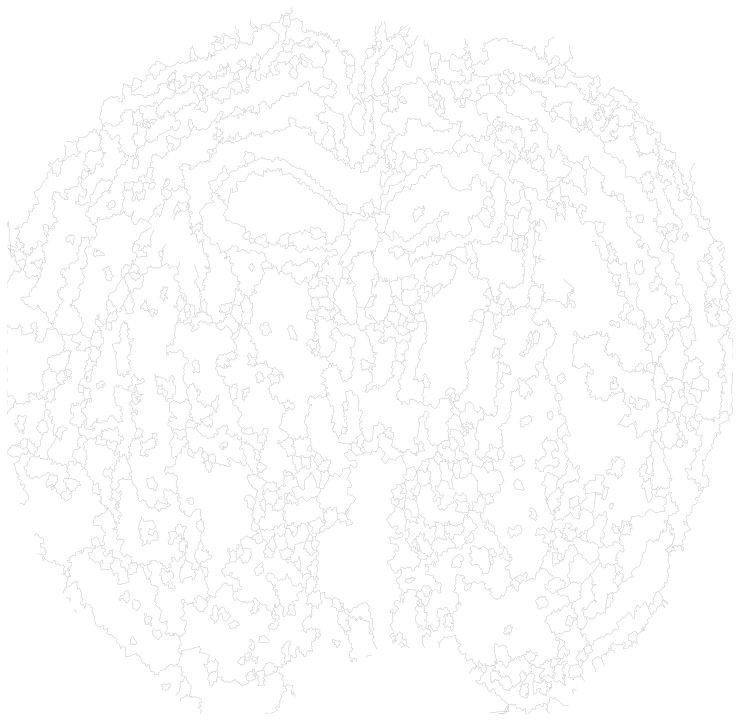

In [218]:
Vlines = OnlyLines2(TMG,0)
Vlines.set_view()
Vlines.plot()
    
    

In [175]:
mx_edge_lvl_dict = TMG.find_max_edge_level()
line_dict = TMG.Geoms['line']
line_dict[(0,13)]

KeyError: (0, 13)

In [193]:
len(TMG.Layers[0].SG.es)

293282

In [183]:
line_keys = np.unique(np.array(list(line_dict.keys())),axis=0)
line_keys

array([[    6,     4],
       [    7,     2],
       [   10,     5],
       ...,
       [97785, 95964],
       [97785, 97767],
       [97785, 97780]])

In [88]:
lines_keys = sorted(list(TMG.Geoms['line'].keys()))

edge_levels = TMG.find_max_edge_level()
edge_level_keys = edge_levels.keys()
# edge_levels
# edge_levels[sorted(lines_keys[0])]

In [110]:
XY = TMG.Layers[0].XY
vor = Voronoi(XY)
dd=Delaunay(XY)
EL = np.zeros((dd.simplices.shape[0]*3,2))
for i in range(dd.simplices.shape[0]): 
    EL[i*3,:]=[dd.simplices[i,0],dd.simplices[i,1]]
    EL[i*3+1,:]=[dd.simplices[i,0],dd.simplices[i,2]]
    EL[i*3+2,:]=[dd.simplices[i,1],dd.simplices[i,2]]
    


In [160]:
TMG.add_geoms()
TMG.save('TMG_dev5.pkl')

In [159]:
ELsrt = np.sort(EL,axis=1)
print(ELsrt.shape)
ELunq = np.unique(ELsrt,axis=0)
print(ELunq.shape)

ELvor = np.array(vor.ridge_points)
ELvor = np.sort(EL3,axis=1)
ELvor = np.unique(ELvor,axis=0)
print(ELvor.shape)

np.all(np.equal(ELunq,ELvor))



(586491, 2)
(293282, 2)
(293282, 2)


True

In [118]:
EL2 = np.zeros((len(TMG.Layers[0].SG.es),2))
for i in range(len(TMG.Layers[0].SG.es)): 
    EL2[i,:]=np.array(TMG.Layers[0].SG.es[i].tuple)

In [130]:
np.all(np.equal(dd.points,vor.points))

True

In [123]:
np.flatnonzero(np.logical_and(EL[:,0]==0,EL[:,1]==13))
# np.flatnonzero(np.logical_and(EL2[:,0]==0,EL2[:,1]==13))

array([], dtype=int64)

In [106]:
pnts = np.array(vor.ridge_points)
np.flatnonzero(pnts[:,1]==13)

array([], dtype=int64)

In [100]:
e = TMG.Layers[0].SG.es[0]
e.tuple



(0, 13)